*This study was conducted for skills demonstration purposes only*

# **Forecasting the UK Construction Sector with Macroeconomic Indicators**
# Section 5. Modeling

This section builds on the Exploratory Data Analysis (EDA) insights to develop predictive models for forecasting UK construction sector trends with macroeconomic indicators. Using identified correlations and time-lags, we implement lagged regression and Vector Autoregression (VAR) models to capture the dynamic relationships between variables like GDP, inflation, and construction output, material prices, and new contracts. The models account for black swan events (e.g., 2008 crisis, Brexit, COVID-19) via dummy variables, aiming to provide accurate forecasts and address the research questions on predictive power and lagged effects.

## Research Questions

1. How do construction related variables (e.g., output, material costs, new contracts) correlate with economic indicators (e.g., GDP growth, interest rates, inflation, employment rates)?

2. Can macroeconomic indicators predict construction trends?

4. Do these macroeconomic indicators impact construction activity immediately, or with a time lag?
<br> If so, what is the typical delay between an economic change and a response in construction output or material prices?

5. Can macroeconomic indicators be used to accurately forecast future construction trends?
<br> How effective are models such as lagged regression or VAR in making such predictions?

6. How so-called 'black swans' (e.g., Brexit, COVID-19) influenced construction industry?

## Sutable models and techniques review

For addressing the research questions  the models that handle time-series data and lagged relationships can be used.

- **Cross-Correlation Analysis**
<br>Identifies the lag at which two time-series (e.g., GDP and construction output) exhibit the strongest correlation.
<br>Computes the correlation coefficient between a macroeconomic indicator and a construction indicator at various lag lengths (e.g., 0 to 12 months).

- **Engle-Granger cointegration test**
<br>Checks whether two non-stationary time series are linked by a stable long-term relationship.
<br>Regressing one series on the other. Testing the residuals for stationarity (using the ADF test).

- **Vector Error Correction Models (VECM)**
<br>Captures both the short-run dynamics and long-run equilibrium between cointegrated variables.
<br>Ensures that deviations from the long-term relationship (e.g., GDP and employment) are corrected over time, while also modeling short-term fluctuations through lagged differences.

- **Granger Causality Test**
<br>Tests whether one time-series (e.g., GDP) can predict another (e.g., construction output) at specific lags.
<br>Assesses if lagged values of one variable improve predictions of another, indicating causality and lag length.

- **Lagged Regression**
<br>Suitable for capturing the effect of lagged macroeconomic variables on construction indicators.
<br>Can be used for prediction  with time lags.

- **Vector Autoregression (VAR) with Lag Selection**
<br>Models multivariate time-series and identifies optimal lags for all variables simultaneously.
<br>VAR models each variable as a function of its own lags and lags of other variables, with lag length determined by criteria like AIC or BIC.

- **Distributed Lag Models (DLM)**
<br>Explicitly models the effect of a predictor’s lagged values on the dependent variable.
<br>Regresses a construction indicator (e.g., material prices) on multiple lagged values of a macroeconomic indicator (e.g., CPIH).

- **ARIMAX with Exogenous Lags**
<br>Extends ARIMA to include lagged exogenous variables, identifying their influence on the target variable.
<br>Models a construction indicator (e.g., output) with its own lags and lagged exogenous variables (e.g., GDP, CPIH).

- **Machine Learning Models**
<br>Random Forest or Gradient Boosting (e.g., XGBoost) for non-linear relationships.
<br>Recurrent Neural Networks (RNNs) or LSTMs for complex time-series patterns.

## Modeling plan

1. **Cross-Correlation Analysis**
This method will be used to confirm and refine the EDA-identified lags.

2. **Engle-Granger cointegration test**
This method will be used to check if series share a common trend because of a real economic link or their correlation is spurious.

3. **Vector Error Correction Models (VECM)**
This model will be used to test whether the series share long-run equilibrium links and to estimate how quickly construction variables adjust when macro conditions change.

5. **Granger Causality test**
Causality for significant correlations to validate predictive relationships will be tested.

6. **Vector Autoregression (VAR)**
Multivariate modeling which let the model select optimal lags via AIC/BIC will be carried out.
Key variables (e.g., construction output, GDP, CPIH, employment rate) and dummy variables for black swan events will be included.


7. **Forecasting with ARIMAX**
This model will be used for single-indicator forecasting with exogenous lags.

Further study and possible extensions of it may use other methods and models.

## Tools and Libraries

In [4021]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import ccf
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import coint
from statsmodels.tsa.vector_ar.vecm import VECM, select_order
import re
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.statespace.sarimax import SARIMAX
import itertools
from statsmodels.stats.diagnostic import acorr_ljungbox, het_arch
from sklearn.metrics import mean_absolute_error, mean_squared_error

## Auxiliary Functions

In [4022]:
# Functions for ARIMAX pipeline

#1. Creating lagged exogs where lag_map = {exog: lag}
def creating_X_lagged(df_arimax, lag_map):
    lagged_frames = []
    for col, L in lag_map.items():
        lagged_frames.append(
            df_arimax[[col]].shift(L).rename(columns={col: f"{col}_lag{L}"})
        )
    X_lagged = pd.concat(lagged_frames, axis=1).dropna()
    return X_lagged


# 2. Standardizing continuous exogs and target variable

def creating_X_std(X_lagged):
    # Creating dictionaries to store standardized columns
    standardized_cols = {}
    # Calculating standardized values for each numerical column
    for column in X_lagged.columns:
        # Standardization (mean=0, std=1)
        standardized_cols[column] = (X_lagged[column] - X_lagged[column].mean()) / X_lagged[column].std(ddof=0)
    # Converting dictionaries to DataFrames
    X_lagged_std = pd.DataFrame(standardized_cols, index=X_lagged.index)

    return X_lagged_std
    

def creating_y_std(y):
    y_std = (y - y.mean()) / y.std(ddof=0)
    
    return y_std

# 3. Joining target variable + trimmed exogs + needed dummies
def creating_y_X(target_col, df_arimax, y_std, X_lagged_std, dummy_candidates):
    X_dummies = df_arimax[dummy_candidates]

    df_mod = pd.concat(
        [y_std, X_lagged_std, X_dummies],
        axis=1
    ).dropna()

    y = df_mod[[target_col]]
    X = df_mod.drop(columns=[target_col])
    return y, X

# 4. Train-test split
def train_test_split(y, X, h):
    return y.iloc[:-h], y.iloc[-h:], X.iloc[:-h], X.iloc[-h:]

# 5. Fitting ARIMAX without MA (compare (1,0,0) vs (0,0,0)) and picking by AIC

def fit_order_candidates(y, X, orders=((1,0,0),(0,0,0))):
    best_res = None
    best_order = None
    best_aic = float('inf')
    for order in orders:
        try:
            m = SARIMAX(
                y, exog=X, order=order, trend='n',
                enforce_stationarity=False, enforce_invertibility=False,
                concentrate_scale=True
            ).fit(method='lbfgs', maxiter=2000, disp=False)
            if m.aic < best_aic:
                best_aic = m.aic
                best_res = m
                best_order = order
        except Exception as e:
            print(f"Order {order} failed: {e}")
    return best_res, best_order

# Convertation PeriodIndex -> DatetimeIndex (for plotting)
def to_dt(idx):
    try:
        return idx.to_timestamp()
    except AttributeError:
        return idx

## Loading data

In [4023]:
#Reading data
df_m_diff = pd.read_parquet('df_m_model_diff.parquet')
df_q_diff = pd.read_parquet('df_q_model_diff.parquet')

df_q_raw = pd.read_parquet('df_q_eda.parquet')
df_q_raw_add = pd.read_parquet('df_q_eda_add.parquet')

In [4024]:
#check data types: Index should be DatetimeIndex and PeriodIndex, other columns - numerical
print(type(df_m_diff.index))  
print(df_m_diff.dtypes)
print(type(df_q_diff.index))  
print(df_q_diff.dtypes)

<class 'pandas.core.indexes.datetimes.DatetimeIndex'>
CPIH_yoy                               float64
Production GDP                         float64
Services GDP                           float64
EUR/GBP                                float64
USD/GBP                                float64
Construction output                    float64
Constr Material Price Index            float64
Govt Expenditure, £m                   float64
BoE Rate, %                            float64
FYStartSpend\_WIN\_2012-04\_2012-05      int64
Brexit_WIN_2016-07_2016-10               int64
COVID_TC_2020-03                       float64
COVID_AO_2020-04                         int64
PolicySupport_WIN_2020-04_2020-12        int64
Reopen_AO_2020-06                        int64
MaterialsSpike_WIN_2021H2                int64
PolicyUnwind_AO_2022-03                  int64
EnergyShock_WIN_2022-03_2022-06          int64
EnergySupport_WIN_2022-10_2023-03        int64
dtype: object
<class 'pandas.core.indexes.period.Peri

## 1. Cross-Correlation Analysis

We apply cross-correlation analysis to explore potential lead lag relationships between macroeconomic drivers and construction indicators. Here, a positive lag means the macro variable leads construction, while a negative lag indicates the reverse. This step helps identify which variables may carry predictive power for later modeling and planning.

### Quarterly data

In [4025]:
# Helpers (align + standardize once; positive lag = MACRO leads)
def _align_and_standardize(x, y):
    """Align by index, drop NaNs once, then z-score using population std (ddof=0)."""
    z = pd.concat([x, y], axis=1).dropna()
    x0 = z.iloc[:, 0].to_numpy(dtype=float)
    y0 = z.iloc[:, 1].to_numpy(dtype=float)
    xn = (x0 - x0.mean()) / x0.std(ddof=0)
    yn = (y0 - y0.mean()) / y0.std(ddof=0)
    return xn, yn, len(z)

def _corr_at_lag_constant_den(xn, yn, k, n):
    """
    r(k) = corr(X_t, Y_{t+k}) computed like statsmodels.ccf with unbiased=False:
    constant denominator n; overlap multiplies are dot products over the overlap.
    """
    if k > 0:     # macro leads
        a, b = xn[:n-k], yn[k:]
        neff = n - k
    elif k < 0:   # construction leads
        kk = -k
        a, b = xn[kk:], yn[:n-kk]
        neff = n - kk
    else:
        a, b = xn, yn
        neff = n
    # same denominator n as statsmodels' ccf(..., unbiased=False)
    val = float(np.dot(a, b) / n) if neff > 0 else np.nan
    return val, neff

# Cross-corr style (both sides), but with explicit loop so sign is exactly ours
def cross_corr_best_lag_both_sides(x, y, K=12):
    xn, yn, n = _align_and_standardize(x, y)
    vals, lags, neffs = [], [], []
    for k in range(-K, K+1):
        v, ne = _corr_at_lag_constant_den(xn, yn, k, n)
        vals.append(v); lags.append(k); neffs.append(ne)
    i = int(np.nanargmax(np.abs(vals)))
    k_star = int(lags[i]); v_star = float(vals[i]); neff = int(neffs[i])
    band = 1.96 / np.sqrt(neff) if neff > 0 else np.nan
    return k_star, v_star, band

# Manual lagged-corr method using shifts, but numerically identical math
def manual_best_lag_both_sides(x, y, K=12):
    # Use the same standardized arrays as cross-corr to avoid numeric drift
    xn, yn, n = _align_and_standardize(x, y)
    best_k, best_v, best_neff = 0, np.nan, 0
    for k in range(-K, K+1):
        v, ne = _corr_at_lag_constant_den(xn, yn, k, n)
        if np.isnan(v):
            continue
        if np.isnan(best_v) or abs(v) > abs(best_v):
            best_k, best_v, best_neff = k, v, ne
    band = 1.96 / np.sqrt(best_neff) if best_neff > 0 else np.nan
    return best_k, best_v, band

# Zero-lag for your table's 'Correlation' column (same alignment you used)
def zero_lag_corr(x, y):
    z = pd.concat([x, y], axis=1).dropna()
    return z.iloc[:, 0].corr(z.iloc[:, 1])

# Creating a table
rows = []
for m in macro_cols:
    for c in cons_cols:
        r0 = zero_lag_corr(q[m], q[c])
        k_ccf, v_ccf, b_ccf = cross_corr_best_lag_both_sides(q[m], q[c], K=K)
        sig_ccf = (abs(v_ccf) > b_ccf) if pd.notna(v_ccf) else False

        k_man, v_man, b_man = manual_best_lag_both_sides(q[m], q[c], K=K)
        sig_man = (abs(v_man) > b_man) if pd.notna(v_man) else False

        rows.append([m, c, r0,
                     k_ccf, v_ccf, sig_ccf,
                     k_man, v_man, sig_man])

ccf_table_fixed = (
    pd.DataFrame(rows, columns=[
        'Macroeconomic',
        'Construction',
        'Correlation',
        'Optimal lag k, cross-corr method',
        'Max Cross-Correlation',
        'statistical significance cross-corr results, 95% confidence',
        'Optimal lag k, manual lagged corr method',
        'Max Cross-Correlation_manual',
        'statistical significance manual lagged corr lesults, 95% confidence'
    ])
    .sort_values(by='Max Cross-Correlation', key=np.abs, ascending=False)
    .reset_index(drop=True)
)

ccf_table_fixed.head(20)


,Macroeconomic,Construction,Correlation,"Optimal lag k, cross-corr method",Max Cross-Correlation,"statistical significance cross-corr results, 95% confidence","Optimal lag k, manual lagged corr method",Max Cross-Correlation_manual,"statistical significance manual lagged corr lesults, 95% confidence"
0,Services GDP,Construction output,0.919247,0,0.919247,True,0,0.919247,True
1,Production GDP,Construction output,0.851520,0,0.851520,True,0,0.851520,True
2,Services GDP,New Contracts - Private Commercial,0.630481,0,0.630481,True,0,0.630481,True
3,Services GDP,New Contracts - Private Housing,0.618868,0,0.618868,True,0,0.618868,True
4,Production GDP,New Contracts - Private Housing,0.600805,0,0.600805,True,0,0.600805,True
5,"Govt Expenditure, £m",Construction output,-0.565050,0,-0.565050,True,0,-0.565050,True
6,Production GDP,New Contracts - Private Commercial,0.531094,0,0.531094,True,0,0.531094,True
7,Production GDP,New Contracts - Private Industrial,0.508163,0,0.508163,True,0,0.508163,True
8,Services GDP,New Contracts - Infrastructure,0.485903,0,0.485903,True,0,0.485903,True
9,Services GDP,New Contracts - Private Industrial,0.459324,0,0.459324,True,0,0.459324,True


## Quarterly Data Cross-Correlation Insights


| Row | Macro variable         | Construction variable              | Lag (k) | Who leads?         | Max Corr | Key Insight                                                                                                               |
| --- | ---------------------- | ---------------------------------- | ------- | ------------------ | -------- | ------------------------------------------------------------------------------------------------------------------------- |
| 0   | Services GDP           | Construction output                | 0       | –                  | 0.919    | Very strong contemporaneous comovement. Services activity and construction output move together.                          |
| 1   | Production GDP         | Construction output                | 0       | –                  | 0.852    | Strong contemporaneous correlation. Industrial production and construction output move in sync.                           |
| 2   | CPIH\_yoy              | Constr Material Price Index        | −4      | **Materials lead** | 0.643    | Materials inflation leads consumer inflation by \~1 year.                                                                 |
| 3   | Business Investment %Δ | Construction output                | 0       | –                  | 0.641    | Investment growth is tightly coupled with construction output at zero lag.                                                |
| 4   | Services GDP           | New Contracts – Private Commercial | 0       | –                  | 0.630    | Services activity aligns with commercial contract awards.                                                                 |
| 5   | Services GDP           | New Contracts – Private Housing    | 0       | –                  | 0.619    | Housing contracts are contemporaneous with services cycles.                                                               |
| 6   | Production GDP         | New Contracts – Private Housing    | 0       | –                  | 0.601    | Private housing contracts move with production activity.                                                                  |
| 7   | Govt Expenditure       | Construction output                | 0       | –                  | −0.565   | Negative contemporaneous link: fiscal spending and construction output often move in opposite directions (crowding-out?). |
| 8   | Production GDP         | New Contracts – Private Commercial | 0       | –                  | 0.531    | Industrial output aligns with commercial contracts.                                                                       |
| 9   | Production GDP         | New Contracts – Private Industrial | 0       | –                  | 0.508    | Strong zero-lag link between production and private industrial contracts.                                                 |
| 10  | Services GDP           | New Contracts – Infrastructure     | 0       | –                  | 0.486    | Infrastructure contracts track services activity contemporaneously.                                                       |
| 11  | Services GDP           | New Contracts – Private Industrial | 0       | –                  | 0.459    | Services and industrial contracts move together.                                                                          |
| 12  | Production GDP         | Constr Material Price Index        | +7      | **Macro leads**    | 0.448    | Production output leads construction materials cost inflation by \~7 quarters (\~2 years).                                |
| 13  | Production GDP         | New Contracts – Infrastructure     | 0       | –                  | 0.447    | GDP and infrastructure contracts are aligned contemporaneously.                                                           |
| 14  | Govt Expenditure       | New Contracts – Private Housing    | 0       | –                  | −0.422   | Negative contemporaneous relation; spending does not boost private housing contracts directly.                            |
| 15  | Govt Expenditure       | New Contracts – Public Housing     | +5      | **Macro leads**    | 0.416    | Fiscal expenditure precedes public housing contracts by \~5 quarters.                                                     |
| 16  | Business Investment %Δ | New Contracts – Private Commercial | 0       | –                  | 0.413    | Investment cycles align with private commercial contracts.                                                                |
| 17  | Services GDP           | Constr Material Price Index        | +8      | **Macro leads**    | −0.401   | Weak but negative: services GDP leads material prices (possible regime-specific).                                         |
| 18  | Govt Expenditure       | New Contracts – Infrastructure     | 0       | –                  | −0.393   | No strong lag, but mild negative correlation contemporaneously.                                                           |
| 19  | Govt Expenditure       | Workforce Jobs                     | +1      | **Macro leads**    | −0.390   | Fiscal spending slightly precedes weaker employment effects (crowding-out).                                               |


The quarterly results highlight mostly contemporaneous relationships, with a few clear lead–lag dynamics (notably inflation and fiscal variables). One striking finding is that construction materials prices lead general consumer inflation (CPIH) by about one year, which is plausible given the faster adjustment of traded input costs compared to sticky consumer prices. Future work should test the robustness of these lead–lag links across sub-periods, use monthly data for finer resolution, and complement correlation with causal models (e.g. VAR, Granger causality) to better understand directionality.

### Monthly data

In [4026]:
# 1. Choosing targets (construction)
cons_cols_m = ['Construction output', 'Constr Material Price Index']

# 2. Dummy filter
_event_name_rx = re.compile(
    r'(WIN|AO|COVID|Brexit|PolicySupport|Reopen|MaterialsSpike|'
    r'PolicyUnwind|EnergyShock|EnergySupport)', re.IGNORECASE
)

def is_dummy_like(col: pd.Series, name: str) -> bool:
    """Heuristics to catch event dummies even if stored as float."""
    if _event_name_rx.search(name or ''):
        return True
    if pd.api.types.is_bool_dtype(col) or pd.api.types.is_integer_dtype(col):
        return True
    # Treat as dummy if only a few distinct values (e.g., {0,1} or {0,1,-1})
    vals = pd.unique(col.dropna())
    if len(vals) <= 3:
        # all values are in {-1, 0, 1} or subset?
        if set(np.unique(vals)).issubset({-1, 0, 1}):
            return True
        # or clearly binary 0/1 even if float
        if set(np.unique(vals)).issubset({0.0, 1.0}):
            return True
    return False

# numeric columns only
numeric_cols = [c for c in df_m_diff.columns if pd.api.types.is_numeric_dtype(df_m_diff[c])]

# excluding construction targets and dummies
_excluded = []
macro_cols_m = []
for c in numeric_cols:
    if c in cons_cols_m:
        continue
    if is_dummy_like(df_m_diff[c], c):
        _excluded.append(c)
        continue
    macro_cols_m.append(c)

# 3. Core helpers (same math & sign: +k = macro leads)
def _align_and_standardize(x: pd.Series, y: pd.Series):
    z = pd.concat([x, y], axis=1).dropna()
    x0 = z.iloc[:, 0].to_numpy(dtype=float)
    y0 = z.iloc[:, 1].to_numpy(dtype=float)
    xn = (x0 - x0.mean()) / x0.std(ddof=0)
    yn = (y0 - y0.mean()) / y0.std(ddof=0)
    return xn, yn, len(z)

def _corr_at_lag_constant_den(xn: np.ndarray, yn: np.ndarray, k: int, n: int):
    # r(k) = corr(X_t, Y_{t+k}) with constant denominator n
    if k > 0:
        a, b = xn[:n-k], yn[k:]; neff = n - k
    elif k < 0:
        kk = -k; a, b = xn[kk:], yn[:n-kk]; neff = n - kk
    else:
        a, b = xn, yn; neff = n
    val = float(np.dot(a, b) / n) if neff > 0 else np.nan
    return val, neff

def cross_corr_best_lag_both_sides_monthly(x: pd.Series, y: pd.Series, K=18):
    xn, yn, n = _align_and_standardize(x, y)
    vals, lags, neffs = [], [], []
    for k in range(-K, K+1):
        v, ne = _corr_at_lag_constant_den(xn, yn, k, n)
        vals.append(v); lags.append(k); neffs.append(ne)
    i = int(np.nanargmax(np.abs(vals)))
    k_star, v_star, neff = int(lags[i]), float(vals[i]), int(neffs[i])
    band = 1.96 / np.sqrt(neff) if neff > 0 else np.nan
    return k_star, v_star, band

def manual_best_lag_both_sides_monthly(x: pd.Series, y: pd.Series, K=18):
    xn, yn, n = _align_and_standardize(x, y)
    best_k, best_v, best_neff = 0, np.nan, 0
    for k in range(-K, K+1):
        v, ne = _corr_at_lag_constant_den(xn, yn, k, n)
        if np.isnan(v): 
            continue
        if np.isnan(best_v) or abs(v) > abs(best_v):
            best_k, best_v, best_neff = k, v, ne
    band = 1.96 / np.sqrt(best_neff) if best_neff > 0 else np.nan
    return best_k, best_v, band

def zero_lag_corr_monthly(x: pd.Series, y: pd.Series):
    z = pd.concat([x, y], axis=1).dropna()
    return z.iloc[:, 0].corr(z.iloc[:, 1])

# 4. Build the monthly table (dummies excluded)
K_months = 18
rows = []
for m in macro_cols_m:
    for c in cons_cols_m:
        r0 = zero_lag_corr_monthly(df_m_diff[m], df_m_diff[c])

        k_ccf, v_ccf, b_ccf = cross_corr_best_lag_both_sides_monthly(df_m_diff[m], df_m_diff[c], K=K_months)
        sig_ccf = (abs(v_ccf) > b_ccf) if pd.notna(v_ccf) else False

        k_man, v_man, b_man = manual_best_lag_both_sides_monthly(df_m_diff[m], df_m_diff[c], K=K_months)
        sig_man = (abs(v_man) > b_man) if pd.notna(v_man) else False

        rows.append([m, c, r0,
                     k_ccf, v_ccf, sig_ccf,
                     k_man, v_man, sig_man])

ccf_table_monthly = (
    pd.DataFrame(rows, columns=[
        'Macroeconomic',
        'Construction',
        'Correlation',
        'Optimal lag k, cross-corr method',
        'Max Cross-Correlation',
        'statistical significance cross-corr results, 95% confidence',
        'Optimal lag k, manual lagged corr method',
        'Max Cross-Correlation_manual',
        'statistical significance manual lagged corr lesults, 95% confidence'
    ])
    .sort_values(by='Max Cross-Correlation', key=np.abs, ascending=False)
    .reset_index(drop=True)
)

ccf_table_monthly.head(20)


,Macroeconomic,Construction,Correlation,"Optimal lag k, cross-corr method",Max Cross-Correlation,"statistical significance cross-corr results, 95% confidence","Optimal lag k, manual lagged corr method",Max Cross-Correlation_manual,"statistical significance manual lagged corr lesults, 95% confidence"
0,Services GDP,Construction output,0.871483,0,0.871483,True,0,0.871483,True
1,Production GDP,Construction output,0.816408,0,0.816408,True,0,0.816408,True
2,CPIH_yoy,Constr Material Price Index,0.092020,-14,0.551937,True,-14,0.551937,True
3,Services GDP,Constr Material Price Index,-0.065553,16,-0.367935,True,16,-0.367935,True
4,"BoE Rate, %",Constr Material Price Index,-0.235663,-18,0.307327,True,-18,0.307327,True
5,"Govt Expenditure, £m",Construction output,-0.238554,0,-0.238554,True,0,-0.238554,True
6,EUR/GBP,Construction output,-0.080625,1,0.228602,True,1,0.228602,True
7,Production GDP,Constr Material Price Index,-0.176771,16,-0.196060,True,16,-0.196060,True
8,USD/GBP,Construction output,0.021632,1,0.183602,True,1,0.183602,True
9,USD/GBP,Constr Material Price Index,-0.048743,13,0.180024,True,13,0.180024,True


## Monthly Data Cross-Correlation Insights


| Row | Macro variable       | Construction variable       | Lag (k) | Who leads          | Max Corr | Key Insight                                                                                                                   |
| --- | -------------------- | --------------------------- | ------- | ------------------ | -------- | ----------------------------------------------------------------------------------------------------------------------------- |
| 0   | Services GDP         | Construction output         | 0       | –                  | 0.871    | Very strong contemporaneous comovement: services GDP and construction output move together.                                   |
| 1   | Production GDP       | Construction output         | 0       | –                  | 0.816    | Strong zero-lag correlation: industrial production and construction output are tightly aligned.                               |
| 2   | CPIH\_yoy            | Constr Material Price Index | –14     | Materials lead     | 0.552    | Construction materials costs anticipate consumer inflation by \~14 months, consistent with early pass-through of input costs. |
| 3   | Services GDP         | Constr Material Price Index | +16     | Macro leads        | –0.368   | Services GDP negatively leads materials prices with a long lag (\~16 months), possibly cyclical or spurious.                  |
| 4   | BoE Rate, %          | Constr Material Price Index | –18     | Materials lead     | 0.307    | Materials prices move up to 1.5 years before interest rate changes, suggesting cost pressures influence policy.               |
| 5   | Govt Expenditure, £m | Construction output         | 0       | –                  | –0.239   | Negative contemporaneous link: fiscal spending and construction output move in opposite directions (possible crowding-out).   |
| 6   | EUR/GBP              | Construction output         | +1      | Macro leads        | 0.229    | Exchange rate shifts slightly precede construction activity, reflecting sensitivity to import costs.                          |
| 7   | Production GDP       | Constr Material Price Index | +16     | Macro leads        | –0.196   | Industrial production negatively leads materials prices at long lags; may reflect cyclical offset.                            |
| 8   | USD/GBP              | Construction output         | +1      | Macro leads        | 0.184    | USD/GBP fluctuations lead construction output by one month, though the effect is moderate.                                    |
| 9   | USD/GBP              | Constr Material Price Index | +13     | Macro leads        | 0.180    | Dollar exchange rate leads materials prices by about a year, consistent with imported input dynamics.                         |
| 10  | Govt Expenditure, £m | Constr Material Price Index | +16     | Macro leads        | 0.143    | Weak and likely insignificant; fiscal spending shows little predictive power for materials prices.                            |
| 11  | EUR/GBP              | Constr Material Price Index | +17     | Macro leads        | –0.142   | Very weak and unstable negative link at long lag; not reliable.                                                               |
| 12  | CPIH\_yoy            | Construction output         | –11     | Construction leads | 0.057    | Insignificant; construction output does not systematically lead consumer inflation.                                           |
| 13  | BoE Rate, %          | Construction output         | +2      | Macro leads        | –0.038   | Insignificant; short-term rate changes have minimal direct transmission to construction activity.                             |


### Conclusion

Quarterly and monthly analyses both show that GDP (production and services) moves **contemporaneously** with construction output, confirming a tight cyclical link.  
The monthly data, however, reveal **finer lead–lag dynamics**: construction materials costs lead CPI inflation and interest rate decisions by over a year, while exchange rates provide short-horizon signals for construction activity.  
Future research should test these **high-frequency predictors** and explore whether they hold consistently across different economic regimes.

## 2. Cointegration Test (Engle-Granger method)

The cointegration test is a statistical method used in time series analysis to determine whether two or more non-stationary series have a stable long-term equilibrium relationship, despite short-term fluctuations. While non-stationary series (e.g., those with trends) often produce spurious correlations, cointegration helps identify whether their trends are meaningfully connected.

For Cointegration Test original level series will be used. All series should be non-stationary but integrated of order 1 (i.e., stationary after one differencing).

| Series                                                                                      | EG Suitability | Reason                                                  |
|---------------------------------------------------------------------------------------------|----------------|---------------------------------------------------------|
| *Quarterly data*                                                                            |                |                                                         |
| Production GDP                                                                              | Yes            | I(1); stationary after first difference.               |
| Services GDP                                                                                | Yes            | I(1); stationary after first difference.               |
| BoE Rate, %                                                                                 | Yes            | I(1); stationary after first difference.               |
| EUR/GBP                                                                                     | Yes            | I(1); stationary after first difference.               |
| USD/GBP                                                                                     | Yes            | I(1); stationary after first difference.               |
| Govt Expenditure (£m)                                                                       | Yes            | I(1); stationary after first difference.               |
| Construction output                                                                         | Yes            | I(1); stationary after first difference.               |
| Constr Material Price Index                                                                 | Yes            | I(1); stationary after first difference.               |
| Workforce Jobs                                                                              | Yes            | I(1); stationary after first difference.               |
| New Contracts (Public Housing, Private Housing, Private Industrial, Infrastructure, “Other”)| Yes            | All I(1); stationary after first difference.           |
| CPIH (level)                                                                                | No             | Still non-stationary after differencing.               |
| New Contracts – Private Commercial                                                          | No             | Non-stationary after differencing.                     |
| Employment rate                                                                             | No             | Requires second differencing (I(2)); unsuitable for EG.|
| CPIH_yoy                                                                                    | No             | Already stationary (rate/Δ series).                    |
| Business Investment, % change                                                               | No             | Stationary % change, not a level I(1).                 |
| Event dummies (GFC, COVID, EnergyShock, etc.)                                               | No             | Deterministic interventions, not stochastic trends.    |


In [4027]:
df_q_raw.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 77 entries, 2006Q1 to 2025Q1
Freq: Q-DEC
Data columns (total 17 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   CPIH                                77 non-null     float64
 1   Production GDP                      77 non-null     float64
 2   Services GDP                        77 non-null     float64
 3   Employment rate, %                  77 non-null     float64
 4   BoE Rate, %                         77 non-null     float64
 5   EUR/GBP                             77 non-null     float64
 6   USD/GBP                             77 non-null     float64
 7   Business Investment, % change       77 non-null     float64
 8   Govt Expenditure, £m                77 non-null     float64
 9   Construction output                 77 non-null     float64
 10  New Contracts - Public Housing      77 non-null     float64
 11  New Contracts - Private H

In [4028]:
df_q_raw_add.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 76 entries, 2006Q1 to 2024Q4
Freq: Q-DEC
Data columns (total 9 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   Constr Material Price Index                76 non-null     float64
 1   Small construction companies               69 non-null     float64
 2   Medium construction companies              69 non-null     float64
 3   Large construction companies               69 non-null     float64
 4   Number of all construction companies       69 non-null     float64
 5   Employees - Small construction companies   69 non-null     float64
 6   Employees - Medium construction companies  69 non-null     float64
 7   Employees - Large construction companies   69 non-null     float64
 8   Employees - All construction companies     69 non-null     float64
dtypes: float64(9)
memory usage: 5.9 KB


In [4029]:
# Preparing data sets:
df_q_coint1 = df_q_raw[['Production GDP', 'Services GDP',
       'BoE Rate, %', 'EUR/GBP', 'USD/GBP',
       'Govt Expenditure, £m', 'Construction output',
       'New Contracts - Public Housing', 'New Contracts - Private Housing',
       'New Contracts - Infrastructure', 'New contracts - Other',
       'New Contracts - Private Industrial',
       'Workforce Jobs (thousands)']]
df_q_coint2 = df_q_raw_add[['Constr Material Price Index']]
df_q_coint = pd.concat([df_q_coint1, df_q_coint2], axis=1, join='inner')


In [4030]:
# Defining column groups
macro_cols = ['Production GDP', 'Services GDP',
       'BoE Rate, %', 'EUR/GBP', 'USD/GBP',
       'Govt Expenditure, £m']
construction_cols = ['Construction output',
       'New Contracts - Public Housing', 'New Contracts - Private Housing',
       'New Contracts - Infrastructure', 'New contracts - Other',
       'New Contracts - Private Industrial',
       'Workforce Jobs (thousands)', 'Constr Material Price Index']

# Calculating 6x8 correlation matrix
correlation = pd.DataFrame(index=macro_cols, columns=construction_cols)

for macro in macro_cols:
    for constr in construction_cols:
        correlation.loc[macro, constr] = df_q_coint[macro].corr(df_q_coint[constr])

correlation = correlation.astype(float)
correlation

,Construction output,New Contracts - Public Housing,New Contracts - Private Housing,New Contracts - Infrastructure,New contracts - Other,New Contracts - Private Industrial,Workforce Jobs (thousands),Constr Material Price Index
Production GDP,0.417836,-0.155561,0.506162,-0.103446,-0.121567,0.663482,0.677921,-0.066653
Services GDP,0.870144,-0.701626,0.303256,0.200878,-0.666907,0.323277,0.230890,0.857789
"BoE Rate, %",0.313323,0.258524,0.028840,-0.408482,0.192958,0.368903,0.399588,0.095861
EUR/GBP,-0.137267,0.402482,0.386608,-0.249825,0.214853,0.363768,0.151846,-0.471125
USD/GBP,-0.530753,0.738754,-0.005860,-0.288487,0.641378,-0.029747,-0.048590,-0.744463
"Govt Expenditure, £m",0.299284,-0.500446,-0.323981,-0.096794,-0.293343,-0.040996,0.141874,0.570677


In [4031]:
# Leave only pairs with a strong correlation
strong_pairs = correlation[abs(correlation) >= 0.5].stack().reset_index()
strong_pairs.columns = ['Macroeconomic','Construction','Correlation']
# Exclude self-correlations
strong_pairs = strong_pairs[strong_pairs['Macroeconomic'] != strong_pairs['Construction']]
strong_pairs

,Macroeconomic,Construction,Correlation
0,Production GDP,New Contracts - Private Housing,0.506162
1,Production GDP,New Contracts - Private Industrial,0.663482
2,Production GDP,Workforce Jobs (thousands),0.677921
3,Services GDP,Construction output,0.870144
4,Services GDP,New Contracts - Public Housing,-0.701626
5,Services GDP,New contracts - Other,-0.666907
6,Services GDP,Constr Material Price Index,0.857789
7,USD/GBP,Construction output,-0.530753
8,USD/GBP,New Contracts - Public Housing,0.738754
9,USD/GBP,New contracts - Other,0.641378


In [4032]:
# Cointegration Test Using the Engle-Granger method
strong_pairs['Cointegration'] = 0
strong_pairs['Coint_pvalue'] = np.nan
for i in strong_pairs.index:
    x = strong_pairs.iloc[i, 0]
    y = strong_pairs.iloc[i, 1]
    series_x = df_q_coint[x]
    series_y = df_q_coint[y]
    score, pvalue, crit_values = coint(series_x, series_y)
    strong_pairs.loc[i, 'Coint_pvalue'] = pvalue
    if pvalue < 0.05:
        strong_pairs.loc[i, 'Cointegration'] = 1

strong_pairs[strong_pairs['Cointegration'] == 1]

,Macroeconomic,Construction,Correlation,Cointegration,Coint_pvalue
2,Production GDP,Workforce Jobs (thousands),0.677921,1,0.008107
4,Services GDP,New Contracts - Public Housing,-0.701626,1,0.041051
8,USD/GBP,New Contracts - Public Housing,0.738754,1,0.010984
9,USD/GBP,New contracts - Other,0.641378,1,0.003692
12,"Govt Expenditure, £m",Constr Material Price Index,0.570677,1,0.029418


The cointegration test was conducted on selected pairs of macroeconomic and construction indicators to identify long-term equilibrium relationships. Using the Engle-Granger method on I(1) series, several variable pairs were found to be cointegrated, indicating they move together over time despite short-term fluctuations. These cointegrated pairs are suitable candidates for further modeling using Vector Error Correction Models (VECM). Non-cointegrated pairs, by contrast, do not share a stable long-run relationship and should be analyzed with caution in trend-based modeling.

## 3. Vector Error Correction Models (VECM)


VECM will be applied to quarterly macroeconomic indicators (GDP, FX rates, government expenditure) and construction indicators (contracts, materials prices) using their log-transformed levels (for positive-valued series) and raw levels (for rates and exchange rates). The model tests for stable long-run equilibrium links and estimates how quickly construction variables adjust when macro conditions change.

In [4033]:
df_q_coint.columns

Index(['Production GDP', 'Services GDP', 'BoE Rate, %', 'EUR/GBP', 'USD/GBP',
       'Govt Expenditure, £m', 'Construction output',
       'New Contracts - Public Housing', 'New Contracts - Private Housing',
       'New Contracts - Infrastructure', 'New contracts - Other',
       'New Contracts - Private Industrial', 'Workforce Jobs (thousands)',
       'Constr Material Price Index'],
      dtype='object')

In [4034]:
log_vars = [
    'Production GDP','Services GDP','Govt Expenditure, £m','Construction output',
    'Constr Material Price Index','Workforce Jobs (thousands)',
    'New Contracts - Private Housing','New Contracts - Private Commercial',
    'New Contracts - Private Industrial','New Contracts - Public Housing',
    'New Contracts - Infrastructure','New contracts - Other'
]
keep_vars = ['USD/GBP','EUR/GBP','BoE Rate, %']

df_log = pd.DataFrame(index=df_q_coint.index)
for col in df_q_coint.columns:
    if col in log_vars:
        df_log[col] = np.log(df_q_coint[col])
    elif col in keep_vars:
        df_log[col] = df_q_coint[col]
df_log = df_log.dropna()


# Pairs with CONSTRUCTION FIRST (dependant variable)
pairs = [
    ['New Contracts - Public Housing', 'Services GDP'],
    ['New Contracts - Public Housing', 'USD/GBP'],
    ['New contracts - Other',        'USD/GBP'],
    ['Constr Material Price Index',  'Govt Expenditure, £m']
]

def pick_lag(Y, maxlags=8):
    try:
        k = select_order(Y, maxlags=maxlags, deterministic="ci").aic
        return 2 if k is None or (hasattr(k, "is_integer") and np.isnan(k)) else int(k)
    except Exception:
        return 2

# Estimating VECM (log-levels)
for dep, macro in pairs:
    if dep not in df_log.columns or macro not in df_log.columns:
        continue
    Y = df_log[[dep, macro]].dropna()

    k_ar = pick_lag(Y)
    res = VECM(Y, k_ar_diff=k_ar, coint_rank=1, deterministic="ci").fit()

    beta  = pd.Series(res.beta[:, 0], index=Y.columns)
    alpha = pd.Series(res.alpha[:, 0], index=Y.columns)

    # intercepting inside cointegration: c = -mean(beta' * Y)
    c = -np.mean(Y.values @ beta.values)

    # normalizing on FIRST series (construction)
    b_norm   = beta / beta.iloc[0]
    intercept = -c / beta.iloc[0]

    print("\n*******************************************************\n")
    print(f"VECM (log-levels): {dep}  ←  {macro}  |  k_ar_diff={k_ar}")
    print("Long-run relation (elasticity form, normalized on construction variable):")
    # rhs only shows the macro term(s)
    rhs = " ".join([f"+ ({b_norm.iloc[j]:.4f})*log({Y.columns[j]})" for j in range(1, len(Y.columns))])
    print(f"log({Y.columns[0]}) = {intercept:.4f} {(' '+rhs) if rhs else ''}")
    print("Speed of adjustment (alpha):")
    print(alpha.to_string())


*******************************************************

VECM (log-levels): New Contracts - Public Housing  ←  Services GDP  |  k_ar_diff=1
Long-run relation (elasticity form, normalized on construction variable):
log(New Contracts - Public Housing) = 24.8282  + (4.4569)*log(Services GDP)
Speed of adjustment (alpha):
New Contracts - Public Housing   -0.302839
Services GDP                     -0.008457

*******************************************************

VECM (log-levels): New Contracts - Public Housing  ←  USD/GBP  |  k_ar_diff=3
Long-run relation (elasticity form, normalized on construction variable):
log(New Contracts - Public Housing) = 1.8461  + (-2.0129)*log(USD/GBP)
Speed of adjustment (alpha):
New Contracts - Public Housing   -0.242103
USD/GBP                           0.062719

*******************************************************

VECM (log-levels): New contracts - Other  ←  USD/GBP  |  k_ar_diff=2
Long-run relation (elasticity form, normalized on construction variable

| Construction variable (dependent)  | Macro driver     | Long-run elasticity (beta)                                                      | Speed of adjustment (alpha)                                                          | Insight                                                                                       |
| ---------------------------------- | ---------------- | ------------------------------------------------------------------------ | -------------------------------------------------------------------------------- | --------------------------------------------------------------------------------------------- |
| **New Contracts – Public Housing** | Services GDP     | **+4.47**: 1% up in Services GDP -> \~4.5% up in contracts.                 | Contracts adjust (–0.31, stabilizing); Services GDP adjusts very little (–0.01). | Strong elasticity: housing contracts respond sharply to services growth; macro is the anchor. |
| **New Contracts – Public Housing** | USD/GBP          | **–2.02**: 1% up in USD/GBP (GBP depreciation) -> \~2% down in contracts.     | Contracts adjust back (–0.24); FX adjusts slightly (+0.06).                      | Exchange rate shocks strongly impact contracts; GBP strength supports housing activity.       |
| **New Contracts – Other**          | USD/GBP          | **–1.64**: 1% up in USD/GBP -> \~1.6% down in “Other” contracts.              | Contracts adjust back (–0.29); FX adjusts weakly (+0.05).                        | FX stability is important; construction contracts react strongly to currency moves.           |
| **Constr. Material Price Index**   | Govt Expenditure | **–0.94**: 1% up in Govt Expenditure -> \~0.9% down in materials price index. | Materials adjust weakly (–0.03); Govt spending adjusts more (+0.25).             | Fiscal expansion eases materials prices (possible demand-supply or subsidy effects).          |


Construction activity is highly sensitive to macro conditions: services growth boosts contracts, strong GBP supports construction, and fiscal spending helps contain materials costs.

## 4. Granger Causality Test

Granger causality tests examine whether past values of one variable improve the prediction of another, beyond its own history. The test requires stationary series, so we use first-differenced I(1) variables (I(2) variables are not suitable). The goal is to identify short-run predictive links between macroeconomic drivers and construction indicators.

#### Quarterly Data

In [4035]:
df_q_diff.columns

Index(['CPIH_yoy', 'Production GDP', 'BoE Rate, %', 'Services GDP', 'EUR/GBP',
       'USD/GBP', 'Govt Expenditure, £m', 'Employment rate_i2',
       'Business Investment, % change', 'Construction output',
       'Constr Material Price Index', 'Workforce Jobs (thousands)',
       'New Contracts - Private Housing', 'New Contracts - Private Commercial',
       'New Contracts - Private Industrial', 'New Contracts - Public Housing',
       'New Contracts - Infrastructure', 'New contracts - Other',
       'GFC_WIN_2008Q4_2009Q2', 'InfraOrders_AO_2017Q3', 'COVID_AO_2020Q2',
       'FiscalSupport_WIN_2020Q2_2020Q4', 'Reopen_AO_2020Q3',
       'MaterialsSpike_WIN_2021H2', 'EnergyShock_WIN_2022H1',
       'EnergySupport_WIN_2022Q4_2023Q2'],
      dtype='object')

In [4036]:
df_q_i1 = df_q_diff.copy().drop(columns=['Employment rate_i2', 'GFC_WIN_2008Q4_2009Q2', 'InfraOrders_AO_2017Q3', 'COVID_AO_2020Q2',
       'FiscalSupport_WIN_2020Q2_2020Q4', 'Reopen_AO_2020Q3',
       'MaterialsSpike_WIN_2021H2', 'EnergyShock_WIN_2022H1',
       'EnergySupport_WIN_2022Q4_2023Q2'])
df_q_i1.columns

Index(['CPIH_yoy', 'Production GDP', 'BoE Rate, %', 'Services GDP', 'EUR/GBP',
       'USD/GBP', 'Govt Expenditure, £m', 'Business Investment, % change',
       'Construction output', 'Constr Material Price Index',
       'Workforce Jobs (thousands)', 'New Contracts - Private Housing',
       'New Contracts - Private Commercial',
       'New Contracts - Private Industrial', 'New Contracts - Public Housing',
       'New Contracts - Infrastructure', 'New contracts - Other'],
      dtype='object')

In [4037]:
df_q_i1.head(3)

,CPIH_yoy,Production GDP,"BoE Rate, %",Services GDP,EUR/GBP,USD/GBP,"Govt Expenditure, £m","Business Investment, % change",Construction output,Constr Material Price Index,Workforce Jobs (thousands),New Contracts - Private Housing,New Contracts - Private Commercial,New Contracts - Private Industrial,New Contracts - Public Housing,New Contracts - Infrastructure,New contracts - Other
2007Q1,0.027175,-0.009370,0.333333,0.015701,0.004210,0.019493,-868.963321,4.8,0.012695,0.020303,-0.010301,0.014244,0.066849,0.064100,0.290105,0.231229,0.013080
2007Q2,0.025396,-0.010470,0.166667,0.013784,-0.012502,0.016407,1211.012406,1.4,-0.004598,0.006803,0.003015,-0.038156,0.118009,-0.160915,-0.076610,-0.077605,0.090460
2007Q3,0.019450,-0.003784,0.333333,0.010847,-0.002197,0.017049,-3.805559,-4.4,-0.015090,0.013553,0.010695,-0.053251,-0.116483,-0.266905,-0.133531,0.018809,-0.049836


In [4038]:
# defining potential pairs
pairs = []
for i in range(ccf_table_fixed.shape[0]):
    if ccf_table_fixed.iloc[i, 0] in df_q_i1.columns and ccf_table_fixed.iloc[i, 1] in df_q_i1.columns:
        pairs.append([ccf_table_fixed.iloc[i, 0], ccf_table_fixed.iloc[i, 1]])

# running VAR + Granger per pair
for pair in pairs:
    Y = df_q_diff[pair].dropna()

    # selecting lag (quarterly: up to 8)
    sel = VAR(Y).select_order(maxlags=8)
    p = sel.aic if sel.aic is not None else 1
    p = max(1, int(p))

    # fit and test: pair[0] and pair[1]
    res = VAR(Y).fit(p)
    gc = res.test_causality(pair[1], [pair[0]], kind='f')

    print(f"{pair[0]} -> {pair[1]} | lags={res.k_ar} | p={gc.pvalue:.4f}")
    print(gc.summary())
    print('\n************************************************************\n')    


Services GDP -> Construction output | lags=4 | p=0.6680
Granger causality F-test. H_0: Services GDP does not Granger-cause Construction output. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value    df   
----------------------------------------------
        0.5936          2.449   0.668 (4, 118)
----------------------------------------------

************************************************************

Production GDP -> Construction output | lags=1 | p=0.5570
Granger causality F-test. H_0: Production GDP does not Granger-cause Construction output. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value    df   
----------------------------------------------
        0.3466          3.911   0.557 (1, 136)
----------------------------------------------

************************************************************

Services GDP -> New Contracts - Private Commercial | lags=2 | p=0.1778
Granger causality F-t

#### Monthly Data

In [4039]:
df_m_diff.columns

Index(['CPIH_yoy', 'Production GDP', 'Services GDP', 'EUR/GBP', 'USD/GBP',
       'Construction output', 'Constr Material Price Index',
       'Govt Expenditure, £m', 'BoE Rate, %',
       'FYStartSpend\_WIN\_2012-04\_2012-05', 'Brexit_WIN_2016-07_2016-10',
       'COVID_TC_2020-03', 'COVID_AO_2020-04',
       'PolicySupport_WIN_2020-04_2020-12', 'Reopen_AO_2020-06',
       'MaterialsSpike_WIN_2021H2', 'PolicyUnwind_AO_2022-03',
       'EnergyShock_WIN_2022-03_2022-06', 'EnergySupport_WIN_2022-10_2023-03'],
      dtype='object')

In [4040]:
ccf_table_monthly.head(3)

,Macroeconomic,Construction,Correlation,"Optimal lag k, cross-corr method",Max Cross-Correlation,"statistical significance cross-corr results, 95% confidence","Optimal lag k, manual lagged corr method",Max Cross-Correlation_manual,"statistical significance manual lagged corr lesults, 95% confidence"
0,Services GDP,Construction output,0.871483,0,0.871483,True,0,0.871483,True
1,Production GDP,Construction output,0.816408,0,0.816408,True,0,0.816408,True
2,CPIH_yoy,Constr Material Price Index,0.092020,-14,0.551937,True,-14,0.551937,True


In [4041]:
df_m_i1 = df_m_diff.copy().drop(columns=['FYStartSpend\_WIN\_2012-04\_2012-05', 'Brexit_WIN_2016-07_2016-10',
       'COVID_TC_2020-03', 'COVID_AO_2020-04',
       'PolicySupport_WIN_2020-04_2020-12', 'Reopen_AO_2020-06',
       'MaterialsSpike_WIN_2021H2', 'PolicyUnwind_AO_2022-03',
       'EnergyShock_WIN_2022-03_2022-06', 'EnergySupport_WIN_2022-10_2023-03'])
df_m_i1.columns

Index(['CPIH_yoy', 'Production GDP', 'Services GDP', 'EUR/GBP', 'USD/GBP',
       'Construction output', 'Constr Material Price Index',
       'Govt Expenditure, £m', 'BoE Rate, %'],
      dtype='object')

In [4042]:
#making frequency explicit to avoid warnings .
inf = pd.infer_freq(df_m_diff.index)
if inf is None or not inf.startswith('M'):
    df_m_diff = df_m_diff.asfreq('MS')
else:
    df_m_diff = df_m_diff.asfreq(inf)



# defining potential pairs
pairs = []
for i in range(ccf_table_monthly.shape[0]):
    if ccf_table_monthly.iloc[i, 0] in df_m_i1.columns and ccf_table_monthly.iloc[i, 1] in df_m_i1.columns:
        pairs.append([ccf_table_monthly.iloc[i, 0], ccf_table_monthly.iloc[i, 1]])

# running VAR + Granger per pair
for pair in pairs:
    Y = df_m_diff[pair].dropna()

    # selecting lag (monthly: up to 24)
    sel = VAR(Y).select_order(maxlags=24)
    p = sel.aic if sel.aic is not None else 1
    p = max(1, int(p))

    # fit and test: pair[0] and pair[1]
    res = VAR(Y).fit(p)
    gc = res.test_causality(pair[1], [pair[0]], kind='f')

    print(f"{pair[0]} -> {pair[1]} | lags={res.k_ar} | p={gc.pvalue:.4f}")
    print(gc.summary())
    print('\n************************************************************\n')

Services GDP -> Construction output | lags=11 | p=0.0000
Granger causality F-test. H_0: Services GDP does not Granger-cause Construction output. Conclusion: reject H_0 at 5% significance level.
Test statistic Critical value p-value     df   
-----------------------------------------------
         7.182          1.824   0.000 (11, 268)
-----------------------------------------------

************************************************************

Production GDP -> Construction output | lags=5 | p=0.0000
Granger causality F-test. H_0: Production GDP does not Granger-cause Construction output. Conclusion: reject H_0 at 5% significance level.
Test statistic Critical value p-value    df   
----------------------------------------------
         7.708          2.244   0.000 (5, 304)
----------------------------------------------

************************************************************

CPIH_yoy -> Constr Material Price Index | lags=14 | p=0.4321
Granger causality F-test. H_0: CPIH_yoy do

#### Granger Causality. Positive Results Only (p < 0.05)


| Cause (X)        | Effect (Y)                      | Quarterly (lag, p) | Monthly (lag, p) | Notes              |
| ---------------- | ------------------------------- | ------------------ | ---------------- | ------------------ |
| Services GDP     | Construction output             | –                  | lag=11, p=0.0000 | Only monthly       |
| Production GDP   | Construction output             | –                  | lag=5, p=0.0000  | Only monthly       |
| EUR/GBP          | Construction output             | –                  | lag=2, p=0.0004  | Only monthly       |
| USD/GBP          | Construction output             | lag=3, p=0.0415    | lag=2, p=0.0174  | Robust across both |
| BoE Rate, %      | Construction output             | –                  | lag=5, p=0.0000  | Only monthly       |
| Services GDP     | Constr. Material Price Index    | lag=8, p=0.0000    | lag=2, p=0.0003  | Robust across both |
| Production GDP   | Constr. Material Price Index    | lag=8, p=0.0000    | lag=2, p=0.0309  | Robust across both |
| USD/GBP          | Constr. Material Price Index    | lag=4, p=0.0080    | –                | Quarterly only     |
| BoE Rate, %      | Constr. Material Price Index    | lag=8, p=0.0074    | –                | Quarterly only     |
| Govt Expenditure | Workforce Jobs                  | lag=2, p=0.0007    | –                | Quarterly only     |
| Services GDP     | Workforce Jobs                  | lag=1, p=0.0011    | –                | Quarterly only     |
| Production GDP   | Workforce Jobs                  | lag=1, p=0.0209    | –                | Quarterly only     |
| USD/GBP          | New Contracts – Private Comm.   | lag=3, p=0.0037    | –                | Quarterly only     |
| USD/GBP          | New Contracts – Infrastructure  | lag=2, p=0.0309    | –                | Quarterly only     |
| BoE Rate, %      | New Contracts – Private Housing | lag=6, p=0.0459    | –                | Quarterly only     |


Granger Causality tests for quarterly data show significanct results mainly for material prices, jobs, and some contracts, but not for overall construction output. Monthly tests reveal clear causality from GDP, exchange rates, and BoE rate to construction output. Robust results across both frequencies include USD/GBP -> output and GDP -> material prices. Overall, monthly data better captures macro-construction linkages than quarterly data.

## 5. Vector Autoregression (VAR)

The VAR model is a multivariate time series model where each variable depends on its own past values and the past values of the other variables. It is widely used to study how economic and financial indicators interact over time.

For this study, we use:

- Stationary series only
- Variables that are I(1), differenced once
- Variables that are already stationary in rates, % changes, or dummy form
- Excluding any I(2) variables (e.g., Employment rate_i2)

Although ARIMAX is our main forecasting tool, we included a VAR step to better understand the dynamic interdependence between macroeconomic drivers and construction indicators. VAR allows us to test how shocks in one variable propagate through the system, providing structural insights (via impulse responses and variance decompositions) that complement the Granger causality results. In other words, VAR is not used for forecasting here, but as a diagnostic step to confirm and visualize the predictive relationships before building the ARIMAX models.

In [4043]:
df_q_diff.columns

Index(['CPIH_yoy', 'Production GDP', 'BoE Rate, %', 'Services GDP', 'EUR/GBP',
       'USD/GBP', 'Govt Expenditure, £m', 'Employment rate_i2',
       'Business Investment, % change', 'Construction output',
       'Constr Material Price Index', 'Workforce Jobs (thousands)',
       'New Contracts - Private Housing', 'New Contracts - Private Commercial',
       'New Contracts - Private Industrial', 'New Contracts - Public Housing',
       'New Contracts - Infrastructure', 'New contracts - Other',
       'GFC_WIN_2008Q4_2009Q2', 'InfraOrders_AO_2017Q3', 'COVID_AO_2020Q2',
       'FiscalSupport_WIN_2020Q2_2020Q4', 'Reopen_AO_2020Q3',
       'MaterialsSpike_WIN_2021H2', 'EnergyShock_WIN_2022H1',
       'EnergySupport_WIN_2022Q4_2023Q2'],
      dtype='object')

In [4044]:
df_var = df_q_diff.copy()

constr_col = ['Construction output',
       'Constr Material Price Index', 'Workforce Jobs (thousands)',
       'New Contracts - Private Housing', 'New Contracts - Private Commercial',
       'New Contracts - Private Industrial', 'New Contracts - Public Housing',
       'New Contracts - Infrastructure', 'New contracts - Other']
macro_col = ['CPIH_yoy', 'Production GDP', 'BoE Rate, %', 'Services GDP', 'EUR/GBP',
       'USD/GBP', 'Govt Expenditure, £m', 'Business Investment, % change']

# separating dummies (exogenous variables)
dummies = df_var[['GFC_WIN_2008Q4_2009Q2', 'InfraOrders_AO_2017Q3', 'COVID_AO_2020Q2',
       'FiscalSupport_WIN_2020Q2_2020Q4', 'Reopen_AO_2020Q3',
       'MaterialsSpike_WIN_2021H2', 'EnergyShock_WIN_2022H1',
       'EnergySupport_WIN_2022Q4_2023Q2']]

for i in constr_col:
    df_var_i = df_var[[i] + macro_col]

    # fit VAR with exogenous regressors
    model = VAR(endog=df_var_i, exog=dummies)
    results = model.fit(maxlags=4, ic="aic")

    #print(results.summary())
    #print('******************************************************************************')
    #print()
    



| **Construction Variable**               | **Key Macroeconomic Drivers**                                                                                                                                          | **Effect**                                                                         |
| --------------------------------------- | ---------------------------------------------------------------------------------------------------------------------------------------------------------------------- | ---------------------------------------------------------------------------------- |
| **Construction Output**                 | GFC dummy (–0.073, p=0.038) <br> COVID dummy (–0.500, p=0.053, borderline)                                                                                             | Output falls in major crises                                                       |
| **Material Price Index**                | Production GDP lag (–0.598, p=0.001) <br> EUR/GBP lag (–0.190, p=0.025) <br> USD/GBP lag (+0.120, p=0.070, borderline) <br> Business Investment lag (+0.0015, p=0.020) | Lower GDP reduces costs; weaker GBP raises import prices; investment drives demand |
| **New Contracts – Private Housing**     | Energy Support 2022Q4–2023Q2 (–0.484, p=0.038) <br> Own lag (–0.461, p=0.028)                                                                                          | Policy withdrawal lowered housing orders; contracts strongly persistent            |
| **New Contracts – Private Commercial**  | Own lag (–0.705, p=0.001)                                                                                                                                              | Strong self-dependence; no significant macro drivers                               |
| **New Contracts – Private Industrial**  | Own lag (–0.885, p<0.001)                                                                                                                                              | Very persistent; no macro driver significant                                       |
| **New Contracts – Infrastructure**      | Infra orders 2017Q3 dummy (+1.298, p<0.001) <br> Own lag (–0.434, p=0.029)                                                                                             | Structural boost in 2017; persistent dynamics                                      |
| **New Contracts – Other**               | COVID dummy (–3.664, p=0.040) <br> Fiscal Support 2020 (3.227, p=0.059, borderline) <br> EUR/GBP lag (–4.548, p<0.001) <br> Own lag (–0.723, p<0.001)                  | COVID collapse; fiscal support partial offset; weaker GBP reduces orders           |


The split VAR results confirm that construction activity is highly sensitive to macroeconomic shocks and policy interventions. Crisis events such as the GFC and COVID-19 sharply reduced construction output and contracts, with COVID causing a particularly severe collapse in “Other” orders. Exchange rate movements also matter: a weaker GBP raises material prices and reduces contracts, highlighting exposure to import costs. GDP and investment cycles shape demand conditions, with higher GDP easing material price pressures while investment drives demand for materials. Finally, policy measures such as fiscal and energy support play a visible role — withdrawal dampened housing, while targeted fiscal support cushioned other contract types. Overall, construction outcomes are strongly path dependent but remain highly exposed to macroeconomic volatility and policy choices.

## 6. Autoregressive Integrated Moving Average with Exogenous Variables (ARIMAX)

The ARIMAX model is an extension of ARIMA that allows us to include external (exogenous) variables alongside the autoregressive and moving average components of a time series. This makes it useful when we want to explain and forecast a target variable while controlling for the influence of macroeconomic or policy factors.

For this study, we use:
- A stationary target series (differenced if I(1))
- Exogenous variables that are also made stationary (first differences or rates if needed)
- Dummies

We use Granger-causality results to trim exogenous variables because they identify which macro factors predict the target series, so we keep only variables with demonstrated predictive power. This reduces multicollinearity and overfitting, stabilizes estimation, and improves performance.

| Cause (X)        | Effect (Y)                      | Quarterly (lag, p) | Monthly (lag, p) | Notes              |
| ---------------- | ------------------------------- | ------------------ | ---------------- | ------------------ |
| Services GDP     | Construction output             | –                  | lag=11, p=0.0000 | Only monthly       |
| Production GDP   | Construction output             | –                  | lag=5, p=0.0000  | Only monthly       |
| EUR/GBP          | Construction output             | –                  | lag=2, p=0.0004  | Only monthly       |
| USD/GBP          | Construction output             | lag=3, p=0.0415    | lag=2, p=0.0174  | Robust across both |
| BoE Rate, %      | Construction output             | –                  | lag=5, p=0.0000  | Only monthly       |
| Services GDP     | Constr. Material Price Index    | lag=8, p=0.0000    | lag=2, p=0.0003  | Robust across both |
| Production GDP   | Constr. Material Price Index    | lag=8, p=0.0000    | lag=2, p=0.0309  | Robust across both |
| USD/GBP          | Constr. Material Price Index    | lag=4, p=0.0080    | –                | Quarterly only     |
| BoE Rate, %      | Constr. Material Price Index    | lag=8, p=0.0074    | –                | Quarterly only     |
| Govt Expenditure | Workforce Jobs                  | lag=2, p=0.0007    | –                | Quarterly only     |
| Services GDP     | Workforce Jobs                  | lag=1, p=0.0011    | –                | Quarterly only     |
| Production GDP   | Workforce Jobs                  | lag=1, p=0.0209    | –                | Quarterly only     |
| USD/GBP          | New Contracts – Private Comm.   | lag=3, p=0.0037    | –                | Quarterly only     |
| USD/GBP          | New Contracts – Infrastructure  | lag=2, p=0.0309    | –                | Quarterly only     |
| BoE Rate, %      | New Contracts – Private Housing | lag=6, p=0.0459    | –                | Quarterly only     |


In [4045]:
df_arimax = df_q_diff.copy().drop(columns=['Employment rate_i2'])
df_arimax.columns

Index(['CPIH_yoy', 'Production GDP', 'BoE Rate, %', 'Services GDP', 'EUR/GBP',
       'USD/GBP', 'Govt Expenditure, £m', 'Business Investment, % change',
       'Construction output', 'Constr Material Price Index',
       'Workforce Jobs (thousands)', 'New Contracts - Private Housing',
       'New Contracts - Private Commercial',
       'New Contracts - Private Industrial', 'New Contracts - Public Housing',
       'New Contracts - Infrastructure', 'New contracts - Other',
       'GFC_WIN_2008Q4_2009Q2', 'InfraOrders_AO_2017Q3', 'COVID_AO_2020Q2',
       'FiscalSupport_WIN_2020Q2_2020Q4', 'Reopen_AO_2020Q3',
       'MaterialsSpike_WIN_2021H2', 'EnergyShock_WIN_2022H1',
       'EnergySupport_WIN_2022Q4_2023Q2'],
      dtype='object')

#### A) Construction Output. Forecast pipeline

Chosen order (p,d,q): (1, 0, 0)
                                SARIMAX Results                                
Dep. Variable:     Construction output   No. Observations:                   61
Model:                SARIMAX(1, 0, 0)   Log Likelihood                 -11.212
Date:                 Wed, 03 Sep 2025   AIC                             32.425
Time:                         22:05:46   BIC                             42.896
Sample:                     12-31-2007   HQIC                            36.521
                          - 12-31-2022   Scale                            0.085
Covariance Type:                   opg                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
USD/GBP_lag3         0.0588      0.027      2.156      0.031       0.005       0.112
COVID_AO_2020Q2     -6.3483      0.619    -10.259      0.000      -7.561 

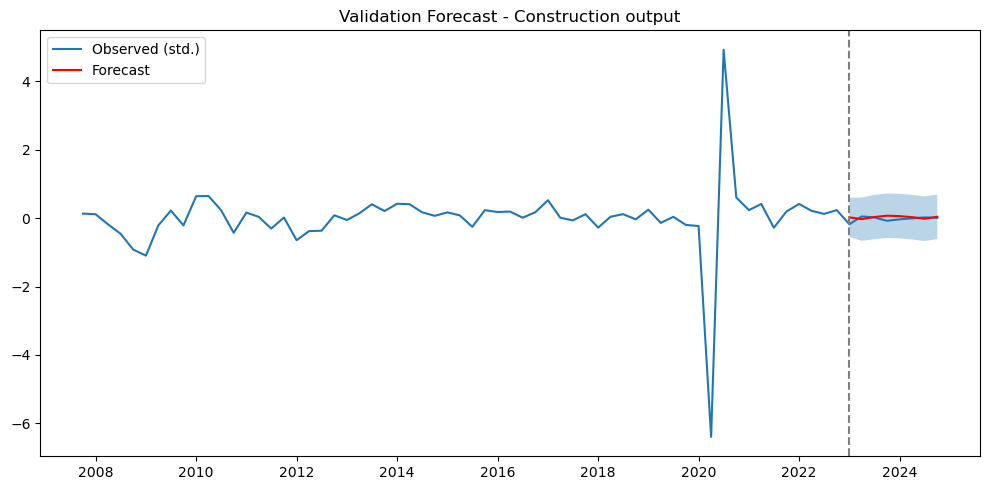

In [4046]:
#Variables for pipeline:
# a) A dictionary where keys are exogenous variables and values are lags (found using the Granger causality test): lag_map={exog:lag}
lag_map = {'USD/GBP': 3}
# b) Column nema of target variable
target_col = 'Construction output'
# c) List of dummies that represent events that are expected to affect the target variable
dummy_candidates = ['COVID_AO_2020Q2', 'Reopen_AO_2020Q3']

# ************************ ARIMAX Pipeline ************************

#1. Creating lagged exogs where lag_map = {exog: lag}
# Auxiliary function: creating_X_lagged(df_arimax, lag_map), where lag_map={exog:lag}
X_lagged = creating_X_lagged(df_arimax, lag_map)


# 2. Standardizing continuous exogs and target variable
# Auxiliary functions: creating_X_std(X_lagged), creating_y_std(y)
X_lagged_std = creating_X_std(X_lagged)
y = df_arimax[[target_col]]
y_std = creating_y_std(y)


# 3. Joining target variable + trimmed exogs + needed dummies
# Auxiliary function: creating_y_X(target_col, df_arimax, y_std, X_lagged_std, dummy_candidates)
y, X = creating_y_X(target_col, df_arimax, y_std, X_lagged_std, dummy_candidates)


# 4. Train-test split
# Auxiliary function: train_test_split(y, X, h)
# forecast horizon (8 quarters)
train_y, test_y, train_X, test_X = train_test_split(y, X, 8)


# 5. Fitting ARIMAX without MA (compare (1,0,0) vs (0,0,0)) and picking by AIC
# Auxiliary function: fit_order_candidates(y, X, orders=((1,0,0),(0,0,0)))
res, chosen_order = fit_order_candidates(train_y, train_X)
print(f"Chosen order (p,d,q): {chosen_order}")


# 6. Refitting on training with selected order
model = SARIMAX(
    train_y, exog=train_X, order=chosen_order,
    trend='n',
    enforce_stationarity=False,
    enforce_invertibility=False,
    concentrate_scale=True
)
res = model.fit(method='lbfgs', maxiter=2000, disp=False)
print(res.summary())


# 7. Validation forecast (h steps)
pred = res.get_forecast(steps=h, exog=test_X)
pred_mean = pred.predicted_mean  # Series
pred_ci = pred.conf_int()  # 2 columns (lower/upper)


# 8. Accuracy metrics (validation)
mae  = mean_absolute_error(test_y, pred_mean)
rmse = np.sqrt(((test_y.values - pred_mean.values)**2).mean())
print(f"Validation MAE:  {mae:.3f}")
print(f"Validation RMSE: {rmse:.3f}")


# 9. Residual diagnostics on training fit
lb = acorr_ljungbox(res.resid, lags=[1], return_df=True)
arch_stat, arch_p, _, arch_p_f = het_arch(res.resid)
print("Ljung–Box p(L=1):", float(lb['lb_pvalue'].iloc[0]))
print("ARCH LM p-value:", float(arch_p))


# 10. Validation forecast (plotting)
# Convertation PeriodIndex -> DatetimeIndex
# Auxiliary Function: 'to_dt(idx)'
y_all    = to_dt(y.index)
pred_idx = to_dt(pred_mean.index)
test_idx = to_dt(test_y.index)

# Plotting the graph
plt.figure(figsize=(10,5))
plt.plot(y_all, y.values, label="Observed (std.)")
plt.plot(pred_idx, pred_mean.values, label="Forecast", color="red")
plt.fill_between(pred_idx, pred_ci.iloc[:,0].to_numpy(), pred_ci.iloc[:,1].to_numpy(), alpha=0.3)
plt.axvline(test_idx[0], linestyle="--", color="grey")
plt.legend()
plt.title("Validation Forecast - " + target_col)
plt.tight_layout()
plt.show()

#### B) Construction Material Price Index. Forecast pipeline

Chosen order (p,d,q): (1, 0, 0)
                                    SARIMAX Results                                    
Dep. Variable:     Constr Material Price Index   No. Observations:                   56
Model:                        SARIMAX(1, 0, 0)   Log Likelihood                 -57.733
Date:                         Wed, 03 Sep 2025   AIC                            131.465
Time:                                 22:05:46   BIC                            147.524
Sample:                             03-31-2009   HQIC                           137.675
                                  - 12-31-2022   Scale                            0.478
Covariance Type:                           opg                                         
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Services GDP_lag8            -0.6619      0.278     -2.378      0.017      -

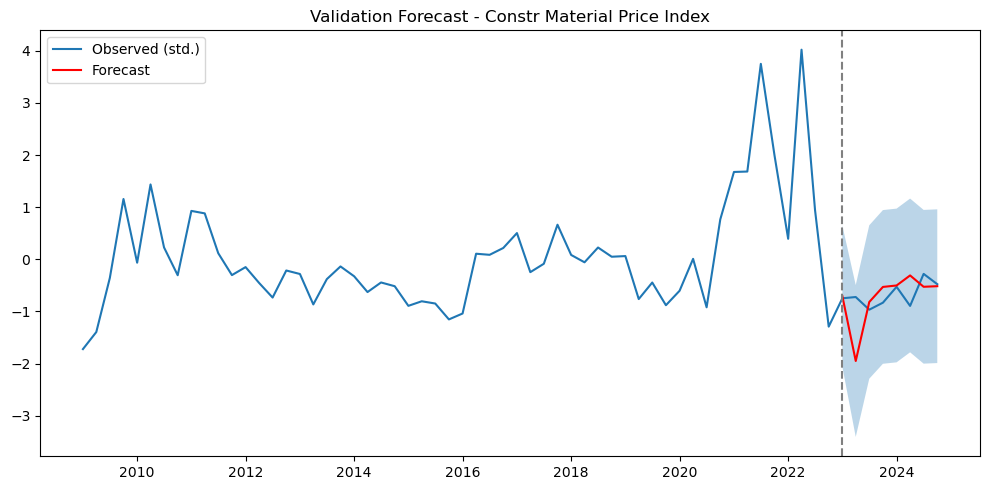

In [4047]:
#Variables for pipeline:
# a) A dictionary where keys are exogenous variables and values are lags (found using the Granger causality test): lag_map={exog:lag}
lag_map = {
    'Services GDP': 8,
    'Production GDP': 8,
    'USD/GBP': 4,
    'BoE Rate, %': 8,
}
# b) Column nema of target variable
target_col = 'Constr Material Price Index'
# c) List of dummies that represent events that are expected to affect the target variable
dummy_candidates = [
    'MaterialsSpike_WIN_2021H2',
    'EnergyShock_WIN_2022H1'
]

# ************************ ARIMAX Pipeline ************************

#1. Creating lagged exogs where lag_map = {exog: lag}
# Auxiliary function: creating_X_lagged(df_arimax, lag_map), where lag_map={exog:lag}
X_lagged = creating_X_lagged(df_arimax, lag_map)


# 2. Standardizing continuous exogs and target variable
# Auxiliary functions: creating_X_std(X_lagged), creating_y_std(y)
X_lagged_std = creating_X_std(X_lagged)
y = df_arimax[[target_col]]
y_std = creating_y_std(y)


# 3. Joining target variable + trimmed exogs + needed dummies
# Auxiliary function: creating_y_X(target_col, df_arimax, y_std, X_lagged_std, dummy_candidates)
y, X = creating_y_X(target_col, df_arimax, y_std, X_lagged_std, dummy_candidates)


# 4. Train-test split
# Auxiliary function: train_test_split(y, X, h)
# forecast horizon (8 quarters)
train_y, test_y, train_X, test_X = train_test_split(y, X, 8)


# 5. Fitting ARIMAX without MA (compare (1,0,0) vs (0,0,0)) and picking by AIC
# Auxiliary function: fit_order_candidates(y, X, orders=((1,0,0),(0,0,0)))
res, chosen_order = fit_order_candidates(train_y, train_X)
print(f"Chosen order (p,d,q): {chosen_order}")


# 6. Refitting on training with selected order
model = SARIMAX(
    train_y, exog=train_X, order=chosen_order,
    trend='n',
    enforce_stationarity=False,
    enforce_invertibility=False,
    concentrate_scale=True
)
res = model.fit(method='lbfgs', maxiter=2000, disp=False)
print(res.summary())


# 7. Validation forecast (h steps)
pred = res.get_forecast(steps=h, exog=test_X)
pred_mean = pred.predicted_mean  # Series
pred_ci = pred.conf_int()  # 2 columns (lower/upper)


# 8. Accuracy metrics (validation)
mae  = mean_absolute_error(test_y, pred_mean)
rmse = np.sqrt(((test_y.values - pred_mean.values)**2).mean())
print(f"Validation MAE:  {mae:.3f}")
print(f"Validation RMSE: {rmse:.3f}")


# 9. Residual diagnostics on training fit
lb = acorr_ljungbox(res.resid, lags=[1], return_df=True)
arch_stat, arch_p, _, arch_p_f = het_arch(res.resid)
print("Ljung–Box p(L=1):", float(lb['lb_pvalue'].iloc[0]))
print("ARCH LM p-value:", float(arch_p))


# 10. Validation forecast (plotting)
# Convertation PeriodIndex -> DatetimeIndex
# Auxiliary Function: 'to_dt(idx)'
y_all    = to_dt(y.index)
pred_idx = to_dt(pred_mean.index)
test_idx = to_dt(test_y.index)

# Plotting the graph
plt.figure(figsize=(10,5))
plt.plot(y_all, y.values, label="Observed (std.)")
plt.plot(pred_idx, pred_mean.values, label="Forecast", color="red")
plt.fill_between(pred_idx, pred_ci.iloc[:,0].to_numpy(), pred_ci.iloc[:,1].to_numpy(), alpha=0.3)
plt.axvline(test_idx[0], linestyle="--", color="grey")
plt.legend()
plt.title("Validation Forecast - " + target_col)
plt.tight_layout()
plt.show()

#### C) Construction Workforce Jobs. Forecast pipeline

Chosen order (p,d,q): (0, 0, 0)
                                   SARIMAX Results                                    
Dep. Variable:     Workforce Jobs (thousands)   No. Observations:                   62
Model:                                SARIMAX   Log Likelihood                 -81.172
Date:                        Wed, 03 Sep 2025   AIC                            170.343
Time:                                22:05:47   BIC                            178.787
Sample:                            09-30-2007   HQIC                           173.652
                                 - 12-31-2022   Scale                            0.838
Covariance Type:                          opg                                         
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Govt Expenditure, £m_lag2    -0.0709      0.203     -0.350      0.726      -0.468   

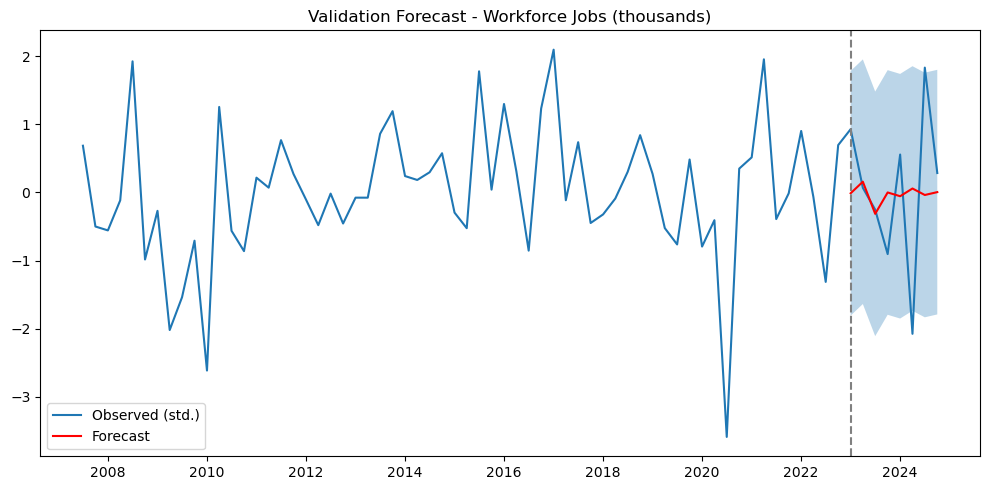

In [4048]:
#Variables for pipeline:
# a) A dictionary where keys are exogenous variables and values are lags (found using the Granger causality test): lag_map={exog:lag}
lag_map = {
    'Govt Expenditure, £m': 2,
    'Services GDP': 1,
    'Production GDP': 1
}
# b) Column nema of target variable
target_col = 'Workforce Jobs (thousands)'
# c) List of dummies that represent events that are expected to affect the target variable
dummy_candidates = []

# ************************ ARIMAX Pipeline ************************

#1. Creating lagged exogs where lag_map = {exog: lag}
# Auxiliary function: creating_X_lagged(df_arimax, lag_map), where lag_map={exog:lag}
X_lagged = creating_X_lagged(df_arimax, lag_map)


# 2. Standardizing continuous exogs and target variable
# Auxiliary functions: creating_X_std(X_lagged), creating_y_std(y)
X_lagged_std = creating_X_std(X_lagged)
y = df_arimax[[target_col]]
y_std = creating_y_std(y)


# 3. Joining target variable + trimmed exogs + needed dummies
# Auxiliary function: creating_y_X(target_col, df_arimax, y_std, X_lagged_std, dummy_candidates)
y, X = creating_y_X(target_col, df_arimax, y_std, X_lagged_std, dummy_candidates)


# 4. Train-test split
# Auxiliary function: train_test_split(y, X, h)
# forecast horizon (8 quarters)
train_y, test_y, train_X, test_X = train_test_split(y, X, 8)


# 5. Fitting ARIMAX without MA (compare (1,0,0) vs (0,0,0)) and picking by AIC
# Auxiliary function: fit_order_candidates(y, X, orders=((1,0,0),(0,0,0)))
res, chosen_order = fit_order_candidates(train_y, train_X)
print(f"Chosen order (p,d,q): {chosen_order}")


# 6. Refitting on training with selected order
model = SARIMAX(
    train_y, exog=train_X, order=chosen_order,
    trend='n',
    enforce_stationarity=False,
    enforce_invertibility=False,
    concentrate_scale=True
)
res = model.fit(method='lbfgs', maxiter=2000, disp=False)
print(res.summary())


# 7. Validation forecast (h steps)
pred = res.get_forecast(steps=h, exog=test_X)
pred_mean = pred.predicted_mean  # Series
pred_ci = pred.conf_int()  # 2 columns (lower/upper)


# 8. Accuracy metrics (validation)
mae  = mean_absolute_error(test_y, pred_mean)
rmse = np.sqrt(((test_y.values - pred_mean.values)**2).mean())
print(f"Validation MAE:  {mae:.3f}")
print(f"Validation RMSE: {rmse:.3f}")


# 9. Residual diagnostics on training fit
lb = acorr_ljungbox(res.resid, lags=[1], return_df=True)
arch_stat, arch_p, _, arch_p_f = het_arch(res.resid)
print("Ljung–Box p(L=1):", float(lb['lb_pvalue'].iloc[0]))
print("ARCH LM p-value:", float(arch_p))


# 10. Validation forecast (plotting)
# Convertation PeriodIndex -> DatetimeIndex
# Auxiliary Function: 'to_dt(idx)'
y_all    = to_dt(y.index)
pred_idx = to_dt(pred_mean.index)
test_idx = to_dt(test_y.index)

# Plotting the graph
plt.figure(figsize=(10,5))
plt.plot(y_all, y.values, label="Observed (std.)")
plt.plot(pred_idx, pred_mean.values, label="Forecast", color="red")
plt.fill_between(pred_idx, pred_ci.iloc[:,0].to_numpy(), pred_ci.iloc[:,1].to_numpy(), alpha=0.3)
plt.axvline(test_idx[0], linestyle="--", color="grey")
plt.legend()
plt.title("Validation Forecast - " + target_col)
plt.tight_layout()
plt.show()

#### D) Number of New Contracts - Private Commercial. Forecast pipeline

Chosen order (p,d,q): (1, 0, 0)
                                       SARIMAX Results                                        
Dep. Variable:     New Contracts - Private Commercial   No. Observations:                   61
Model:                               SARIMAX(1, 0, 0)   Log Likelihood                 -68.259
Date:                                Wed, 03 Sep 2025   AIC                            146.518
Time:                                        22:05:47   BIC                            156.989
Sample:                                    12-31-2007   HQIC                           150.614
                                         - 12-31-2022   Scale                            0.570
Covariance Type:                                  opg                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
USD/GBP_lag3         0.1067      0.114

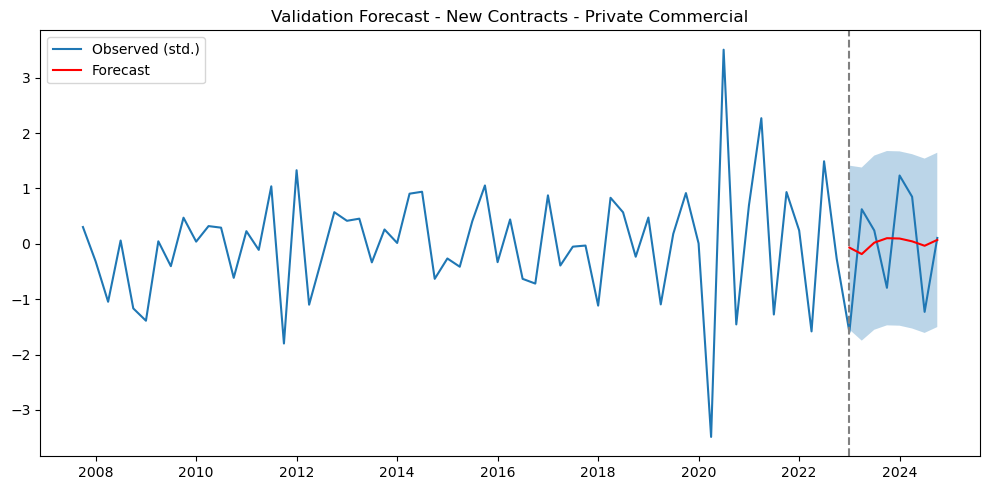

In [4049]:
#Variables for pipeline:
# a) A dictionary where keys are exogenous variables and values are lags (found using the Granger causality test): lag_map={exog:lag}
lag_map = {'USD/GBP': 3}
# b) Column nema of target variable
target_col = 'New Contracts - Private Commercial'
# c) List of dummies that represent events that are expected to affect the target variable
dummy_candidates = ['COVID_AO_2020Q2', 'Reopen_AO_2020Q3']

# ************************ ARIMAX Pipeline ************************

#1. Creating lagged exogs where lag_map = {exog: lag}
# Auxiliary function: creating_X_lagged(df_arimax, lag_map), where lag_map={exog:lag}
X_lagged = creating_X_lagged(df_arimax, lag_map)


# 2. Standardizing continuous exogs and target variable
# Auxiliary functions: creating_X_std(X_lagged), creating_y_std(y)
X_lagged_std = creating_X_std(X_lagged)
y = df_arimax[[target_col]]
y_std = creating_y_std(y)


# 3. Joining target variable + trimmed exogs + needed dummies
# Auxiliary function: creating_y_X(target_col, df_arimax, y_std, X_lagged_std, dummy_candidates)
y, X = creating_y_X(target_col, df_arimax, y_std, X_lagged_std, dummy_candidates)


# 4. Train-test split
# Auxiliary function: train_test_split(y, X, h)
# forecast horizon (8 quarters)
train_y, test_y, train_X, test_X = train_test_split(y, X, 8)


# 5. Fitting ARIMAX without MA (compare (1,0,0) vs (0,0,0)) and picking by AIC
# Auxiliary function: fit_order_candidates(y, X, orders=((1,0,0),(0,0,0)))
res, chosen_order = fit_order_candidates(train_y, train_X)
print(f"Chosen order (p,d,q): {chosen_order}")


# 6. Refitting on training with selected order
model = SARIMAX(
    train_y, exog=train_X, order=chosen_order,
    trend='n',
    enforce_stationarity=False,
    enforce_invertibility=False,
    concentrate_scale=True
)
res = model.fit(method='lbfgs', maxiter=2000, disp=False)
print(res.summary())


# 7. Validation forecast (h steps)
pred = res.get_forecast(steps=h, exog=test_X)
pred_mean = pred.predicted_mean  # Series
pred_ci = pred.conf_int()  # 2 columns (lower/upper)


# 8. Accuracy metrics (validation)
mae  = mean_absolute_error(test_y, pred_mean)
rmse = np.sqrt(((test_y.values - pred_mean.values)**2).mean())
print(f"Validation MAE:  {mae:.3f}")
print(f"Validation RMSE: {rmse:.3f}")


# 9. Residual diagnostics on training fit
lb = acorr_ljungbox(res.resid, lags=[1], return_df=True)
arch_stat, arch_p, _, arch_p_f = het_arch(res.resid)
print("Ljung–Box p(L=1):", float(lb['lb_pvalue'].iloc[0]))
print("ARCH LM p-value:", float(arch_p))


# 10. Validation forecast (plotting)
# Convertation PeriodIndex -> DatetimeIndex
# Auxiliary Function: 'to_dt(idx)'
y_all    = to_dt(y.index)
pred_idx = to_dt(pred_mean.index)
test_idx = to_dt(test_y.index)

# Plotting the graph
plt.figure(figsize=(10,5))
plt.plot(y_all, y.values, label="Observed (std.)")
plt.plot(pred_idx, pred_mean.values, label="Forecast", color="red")
plt.fill_between(pred_idx, pred_ci.iloc[:,0].to_numpy(), pred_ci.iloc[:,1].to_numpy(), alpha=0.3)
plt.axvline(test_idx[0], linestyle="--", color="grey")
plt.legend()
plt.title("Validation Forecast - " + target_col)
plt.tight_layout()
plt.show()

#### E) Number of New Contracts - Infrastructure. Forecast pipeline

Chosen order (p,d,q): (1, 0, 0)
                                     SARIMAX Results                                      
Dep. Variable:     New Contracts - Infrastructure   No. Observations:                   62
Model:                           SARIMAX(1, 0, 0)   Log Likelihood                 -72.841
Date:                            Wed, 03 Sep 2025   AIC                            155.682
Time:                                    22:05:47   BIC                            166.236
Sample:                                09-30-2007   HQIC                           159.818
                                     - 12-31-2022   Scale                            0.638
Covariance Type:                              opg                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
USD/GBP_lag2             -0.1557      0.106     -1.465      

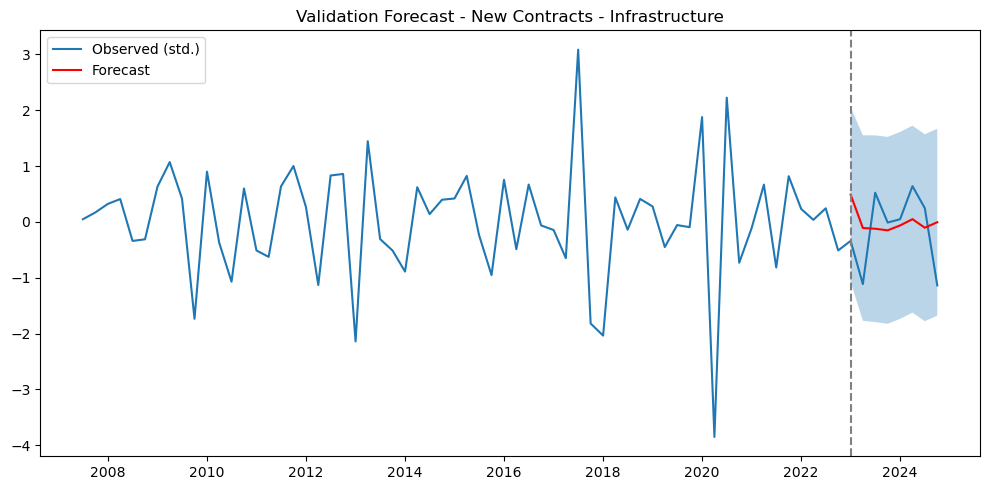

In [4050]:
#Variables for pipeline:
# a) A dictionary where keys are exogenous variables and values are lags (found using the Granger causality test): lag_map={exog:lag}
lag_map = {'USD/GBP': 2}
# b) Column nema of target variable
target_col = 'New Contracts - Infrastructure'
# c) List of dummies that represent events that are expected to affect the target variable
dummy_candidates = ['InfraOrders_AO_2017Q3', 'COVID_AO_2020Q2']

# ************************ ARIMAX Pipeline ************************

#1. Creating lagged exogs where lag_map = {exog: lag}
# Auxiliary function: creating_X_lagged(df_arimax, lag_map), where lag_map={exog:lag}
X_lagged = creating_X_lagged(df_arimax, lag_map)


# 2. Standardizing continuous exogs and target variable
# Auxiliary functions: creating_X_std(X_lagged), creating_y_std(y)
X_lagged_std = creating_X_std(X_lagged)
y = df_arimax[[target_col]]
y_std = creating_y_std(y)


# 3. Joining target variable + trimmed exogs + needed dummies
# Auxiliary function: creating_y_X(target_col, df_arimax, y_std, X_lagged_std, dummy_candidates)
y, X = creating_y_X(target_col, df_arimax, y_std, X_lagged_std, dummy_candidates)


# 4. Train-test split
# Auxiliary function: train_test_split(y, X, h)
# forecast horizon (8 quarters)
train_y, test_y, train_X, test_X = train_test_split(y, X, 8)


# 5. Fitting ARIMAX without MA (compare (1,0,0) vs (0,0,0)) and picking by AIC
# Auxiliary function: fit_order_candidates(y, X, orders=((1,0,0),(0,0,0)))
res, chosen_order = fit_order_candidates(train_y, train_X)
print(f"Chosen order (p,d,q): {chosen_order}")


# 6. Refitting on training with selected order
model = SARIMAX(
    train_y, exog=train_X, order=chosen_order,
    trend='n',
    enforce_stationarity=False,
    enforce_invertibility=False,
    concentrate_scale=True
)
res = model.fit(method='lbfgs', maxiter=2000, disp=False)
print(res.summary())


# 7. Validation forecast (h steps)
pred = res.get_forecast(steps=h, exog=test_X)
pred_mean = pred.predicted_mean  # Series
pred_ci = pred.conf_int()  # 2 columns (lower/upper)


# 8. Accuracy metrics (validation)
mae  = mean_absolute_error(test_y, pred_mean)
rmse = np.sqrt(((test_y.values - pred_mean.values)**2).mean())
print(f"Validation MAE:  {mae:.3f}")
print(f"Validation RMSE: {rmse:.3f}")


# 9. Residual diagnostics on training fit
lb = acorr_ljungbox(res.resid, lags=[1], return_df=True)
arch_stat, arch_p, _, arch_p_f = het_arch(res.resid)
print("Ljung–Box p(L=1):", float(lb['lb_pvalue'].iloc[0]))
print("ARCH LM p-value:", float(arch_p))


# 10. Validation forecast (plotting)
# Convertation PeriodIndex -> DatetimeIndex
# Auxiliary Function: 'to_dt(idx)'
y_all    = to_dt(y.index)
pred_idx = to_dt(pred_mean.index)
test_idx = to_dt(test_y.index)

# Plotting the graph
plt.figure(figsize=(10,5))
plt.plot(y_all, y.values, label="Observed (std.)")
plt.plot(pred_idx, pred_mean.values, label="Forecast", color="red")
plt.fill_between(pred_idx, pred_ci.iloc[:,0].to_numpy(), pred_ci.iloc[:,1].to_numpy(), alpha=0.3)
plt.axvline(test_idx[0], linestyle="--", color="grey")
plt.legend()
plt.title("Validation Forecast - " + target_col)
plt.tight_layout()
plt.show()

| Result | Series & selected order                            | Main signals (significant)                                                                        | Residuals (LB p / ARCH p)              | Validation (MAE / RMSE)                | Conclusion                                                                                                                                                                                                                                                                                                                                       |
| ------ | -------------------------------------------------- | ------------------------------------------------------------------------------------------------- | -------------------------------------- | -------------------------------------- | --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **A**  | Construction Output. ARIMAX(1,0,0)                | USD/GBP lag3 **+** (p=0.031); COVID **–**; Reopen **+**; AR(1) **+**.                             | 0.95 / 0.29 (no autocorr; no ARCH).    | **0.080 / 0.091** (strong).            | Stable, high-quality fit suitable for forecasting.                                                                                                                                                                                                                                                                                                        |
| **B**  | Construction Materials Price Index. ARIMAX(1,0,0) | Services GDP lag8 **–** (p=0.017); Materials-spike **+**; BoE rate lag8 borderline; USD/GBP n.s.  | 0.65 / **0.0013** (**ARCH present**).  | 0.327 / 0.531 (reasonable point fit).  | **Unreliable. Will be omit for this study.** The errors show changing volatility over time (volatility clustering), so the usual standard errors and tests aren’t trustworthy. Next steps in further study: refitting with ARIMAX + GARCH(1,1), using robust standard errors, checking results before vs. after 2021, trying commodity sub-indices or energy futures as inputs, and considering a log transform. |
| **C**  | Workforce Jobs. ARIMAX(0,0,0)                     | Services GDP lag1 **+** (p=0.015); other exogs n.s.                                               | 0.96 / 0.43 (clean).                   | **0.861 / 1.115** (weak).              | Diagnostics OK but predictive power limited; needs to be used cautiously.                                                                                                                                                                                                                                                                                              |
| **D**  | New Contracts - Private Commercial. ARIMAX(1,0,0) | Reopen **+** (p=0.007); AR(1) **–**; USD/GBP lag3 n.s.; COVID n.s.                                | 0.69 / 0.85 (clean).                   | **0.828 / 0.965** (moderate).          | Reasonable baseline; FX/COVID effects need to be interpreted with caution.                                                                                                                                                                                                                                                                                               |
| **E**  | New Contracts - Infrastructure. ARIMAX(1,0,0)     | 2017Q3 dummy **+**; COVID **–**; USD/GBP lag2 n.s.; AR(1) **–**.                                  | 0.63 / 0.69 (clean).                   | **0.601 / 0.680** (solid).             | Dependable baseline for forward projections.                                                                                                                                                                                                                                                                                                              |


A one-lag ARIMAX model was found to work best overall. Construction Output (A) is considered reliable for short-term forecasting and is kept as the baseline, while Infrastructure (E) is regarded as solid for planning. Private Commercial (D) should be used with caution and its forecasts should be stress-tested. Workforce Jobs (C) is judged to add little forecasting value and is kept mainly for context. The Materials Price Index (B) is excluded because unstable volatility makes its results untrustworthy. No leftover pattern in residuals was detected for the retained models, so the one-lag setup is deemed sufficient. For future work, a volatility model for B should be prioritized, rolling re-checks should be performed, and lags should be retuned.

### Authors

[Alisa Makhonina](https://www.linkedin.com/in/alisa-makhonina-data-science/) Data scientist with over 8 years of experience in construction cost engineering. Structural Engineering graduate.